<a href="https://colab.research.google.com/github/Copita12/MLCopita/blob/master/SE%C3%91ALES_Trabajo_Final_Aprendizaje_de_M%C3%A1quinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Señales de tráfico


## Descarga de imagenes

In [3]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

mkdir: cannot create directory ‘dataroot’: File exists
--2021-03-06 17:45:08--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip.3’

data_1.zip.3        100%[===================>]  30.59M   190MB/s    in 0.2s    

2021-03-06 17:45:09 (190 MB/s) - ‘dataroot/data_1.zip.3’ saved [32074743/32074743]

--2021-03-06 17:45:09--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

In [4]:
# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [5]:
# Load sign names
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [6]:
# Load images
import pickle
signimages = pickle.load( open( dataroot+"train.p", "rb" ) )

The image shows a Turn left ahead sign


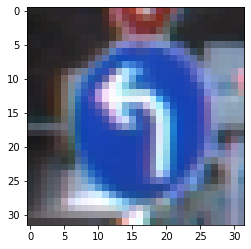

In [49]:
# Preview image
import matplotlib.pyplot as plt
import numpy as np
import cv2

inx = 20123
plt.imshow(signimages['features'][inx])
print("The image shows a {} sign".format(signnames[signimages['labels'][inx]]))

In [61]:
from sklearn.model_selection import train_test_split

X = signimages['features']
y = signimages['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43)

In [9]:
X_test.shape

(17400, 32, 32, 3)

In [10]:
X_train.shape

(17399, 32, 32, 3)

## Descomposición de señales en sus componentes
PCA son las iniciales de Principal Component Analysis y se utiliza frecuentemente para descomponer un conjunto de datos multivariante en un conjunto de componentes ortogonales sucesivos que explican una cantidad máxima de varianza. El parámetro opcional whiten = True hace posible proyectar los datos en el espacio singular mientras escala cada componente a la varianza de la unidad.

Para poder utilizar PCA de sklearn es necesario un dataset 2D para esto se ejecuta un reshape con las dimensiones correspondientes (samples,features)

In [60]:
X_train_re = X_train.reshape(17399,3*32*32)
X_test_re = X_test.reshape(17400,3*32*32)

La clase PCA usada con el parámetro opcional svd_solver = 'randomized' es muy útil para eliminar la mayoría de los vectores singulares, es mucho más eficiente limitar el cálculo a una estimación aproximada de los vectores singulares con los que se realizará la transformación.

Se busca el resultado mas optimo de n_componentes para la descomposicion. Tambien imprimimos el tiempo de entrenamiento, en casos de datasets de gran volumen esto podria ser un problema, se logra percibir por el resultado que este tiempo no tiene relacion lineal con la cantidad de componentes.

In [12]:
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import time

clf = SVC(C=1000,kernel='rbf', class_weight='balanced',gamma=0.001)
res = []

for n in range(1,200,20):
  start_time = time.time()
  pca = PCA(n_components=n, svd_solver='randomized', whiten=True).fit(X_train_re)
  X_train_pca = pca.transform(X_train_re)
  X_test_pca = pca.transform(X_test_re)

  clf = clf.fit(X_train_pca, y_train)
  y_pred = clf.predict(X_test_pca)
  res.append(metrics.f1_score(y_test, y_pred,average='macro'))

  print("--- %s Tiempo de ejecución en Minutos ---" % ((time.time() - start_time)/60))


--- 0.9847345511118571 Tiempo de ejecución en Minutos ---
--- 0.6882524728775025 Tiempo de ejecución en Minutos ---
--- 0.633021887143453 Tiempo de ejecución en Minutos ---
--- 0.693296472231547 Tiempo de ejecución en Minutos ---
--- 0.8365240414937337 Tiempo de ejecución en Minutos ---
--- 0.9901114662488302 Tiempo de ejecución en Minutos ---
--- 1.1407647490501405 Tiempo de ejecución en Minutos ---
--- 1.3309463143348694 Tiempo de ejecución en Minutos ---
--- 1.5231015880902607 Tiempo de ejecución en Minutos ---
--- 1.7496740420659382 Tiempo de ejecución en Minutos ---


En la gráfica no es apreciable pero, si bien pasando los 60 componentes todos los resultados son mayores a .9 nos quedamos con 80 donde encontramos el máximo.

,n_components,f1_score
0,1,0.007042
1,21,0.703180
2,41,0.870431
3,61,0.914171
4,81,0.919547
5,101,0.916034
6,121,0.916323
7,141,0.915422
8,161,0.916277
9,181,0.915040


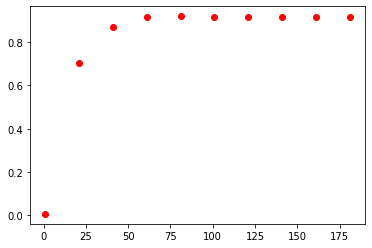

In [13]:
d = {'n_components': range(1,200,20),'f1_score':res}
df = pd.DataFrame(data=d)
plt.scatter(df['n_components'],df['f1_score'],c='r')
df

In [116]:
pca = PCA(n_components=80, svd_solver='randomized', whiten=True).fit(X_train_re)
X_train_pca = pca.transform(X_train_re)
X_test_pca = pca.transform(X_test_re)

clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

Evaluamos con una matriz de confusión para comprobar la veracidad del método

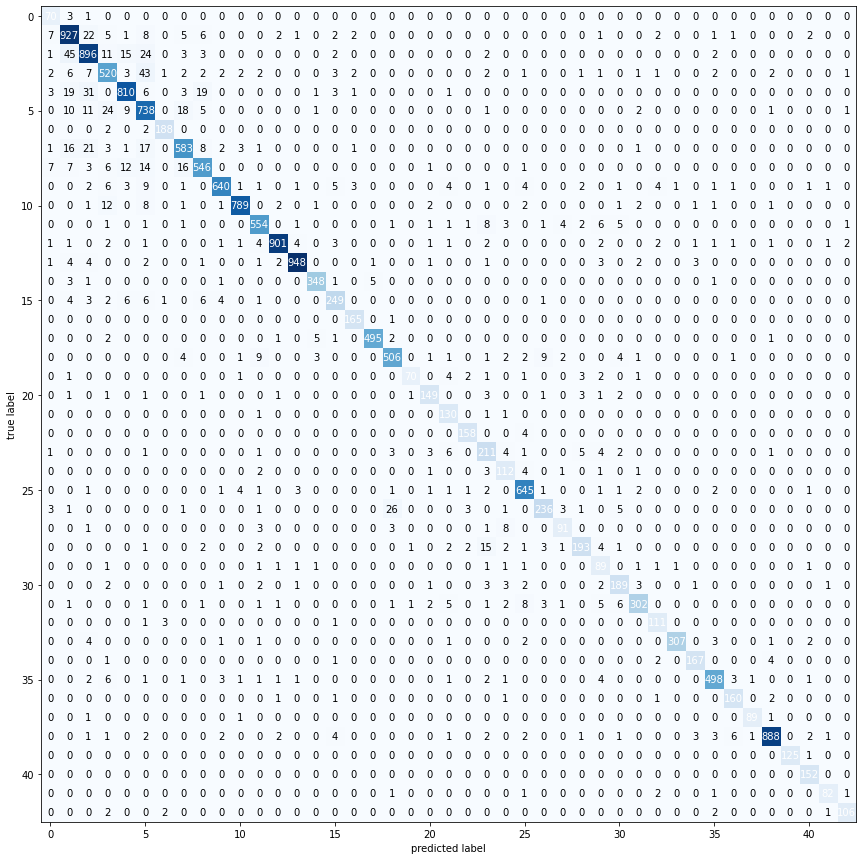

In [15]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.pyplot import subplots

cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)
fig, ax = plot_confusion_matrix(conf_mat=cm,figsize=(15,15))
plt.show()

Y también con algunos estimadores por cada target

In [117]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83        74
           1       0.89      0.93      0.91       995
           2       0.88      0.89      0.89      1004
           3       0.84      0.85      0.85       609
           4       0.94      0.91      0.92       897
           5       0.83      0.90      0.86       821
           6       0.95      0.97      0.96       192
           7       0.92      0.90      0.91       658
           8       0.92      0.89      0.90       613
           9       0.97      0.91      0.94       693
          10       0.98      0.96      0.97       825
          11       0.93      0.92      0.93       592
          12       0.99      0.96      0.98       934
          13       0.98      0.97      0.98       974
          14       0.97      0.97      0.97       360
          15       0.91      0.89      0.90       283
          16       0.95      0.99      0.97       166
          17       0.99    

Unas predicciones

The image shows a Keep right sign
The machine predicts a Keep right sign


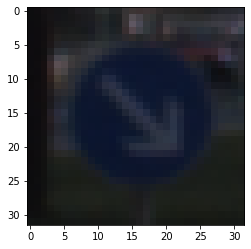

In [85]:
inx = 40

X = signimages['features']
y = signimages['labels']

plt.imshow(X_test[inx])

print("The image shows a {} sign".format(signnames[y_test[inx]]))
print("The machine predicts a {} sign".format(signnames[y_pred[inx]]))

The image shows a Yield sign
The machine predicts a Yield sign


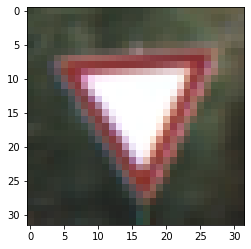

In [87]:
inx = 4000

X = signimages['features']
y = signimages['labels']

plt.imshow(X_test[inx])

print("The image shows a {} sign".format(signnames[y_test[inx]]))
print("The machine predicts a {} sign".format(signnames[y_pred[inx]]))

No todas son acertadas...

The image shows a Keep right sign
The machine predicts a Turn left ahead sign


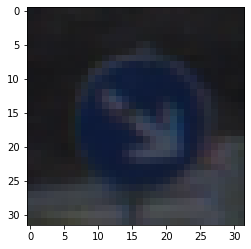

In [110]:
inx = 5081

X = signimages['features']
y = signimages['labels']

plt.imshow(X_test[inx])

print("The image shows a {} sign".format(signnames[y_test[inx]]))
print("The machine predicts a {} sign".format(signnames[y_pred[inx]]))

## UMAP (Uniform Manifold Approximation and Projection)
Es una técnica de reducción de dimensionalidad que se puede utilizar para la visualización de forma similar a t-SNE (t-Distributed Stochastic Neighbor Embedding), pero también para la reducción de dimensión no lineal general. La incrustación se encuentra buscando una proyección de baja dimensión de los datos que tenga la estructura topológica difusa equivalente más cercana posible.

In [19]:
X = X.reshape(34799,3*32*32)
X.shape

(34799, 3072)

Buscamos en un rango de entre 2 y 20 la cantidad de vecinos para la cual se obtenga mayor score en con la reducción de UMAP

In [30]:
import umap

clf = SVC(C=1000,kernel='rbf', class_weight='balanced',gamma=0.001)
res = []

for n in range(2,20,2):
  start_time = time.time()
  reducer = umap.UMAP(n_neighbors=n,
                      min_dist=0.3,
                      metric='correlation')
  reducer.fit(X_train_re)
  X_train_reducer = reducer.transform(X_train_re)
  X_test_reducer = reducer.transform(X_test_re)

  clf = clf.fit(X_train_reducer, y_train)
  y_pred = clf.predict(X_test_reducer)
  res.append(metrics.f1_score(y_test, y_pred,average='macro'))

  print("--- %s Tiempo de ejecución en Minutos ---" % ((time.time() - start_time)/60))


/usr/local/lib/python3.7/dist-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: sp

--- 3.960768234729767 Tiempo de ejecución en Minutos ---
--- 1.9253545920054118 Tiempo de ejecución en Minutos ---
--- 1.6159562548001607 Tiempo de ejecución en Minutos ---
--- 1.5959753791491191 Tiempo de ejecución en Minutos ---
--- 1.784746813774109 Tiempo de ejecución en Minutos ---
--- 1.8891155560811361 Tiempo de ejecución en Minutos ---
--- 2.091291121641795 Tiempo de ejecución en Minutos ---
--- 2.273456378777822 Tiempo de ejecución en Minutos ---
--- 2.446044659614563 Tiempo de ejecución en Minutos ---


,n_components,f1_score
0,2,0.031782
1,4,0.159057
2,6,0.269043
3,8,0.345208
4,10,0.167557
5,12,0.165580
6,14,0.077476
7,16,0.104139
8,18,0.123821


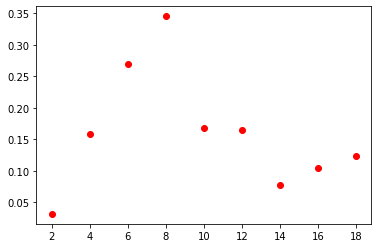

In [32]:
d = {'n_components': range(2,20,2),'f1_score':res}
df = pd.DataFrame(data=d)
plt.scatter(df['n_components'],df['f1_score'],c='r')
df

Entreanamos con n_neighbors = 8 que fue el resultado con mayor puntuación

In [112]:
reducer = umap.UMAP(n_neighbors=8,
                      min_dist=0.3,
                      metric='correlation')
reducer.fit(X_train_re)
X_train_reducer = reducer.transform(X_train_re)
X_test_reducer = reducer.transform(X_test_re)

clf = clf.fit(X_train_reducer, y_train)
y_pred = clf.predict(X_test_reducer)

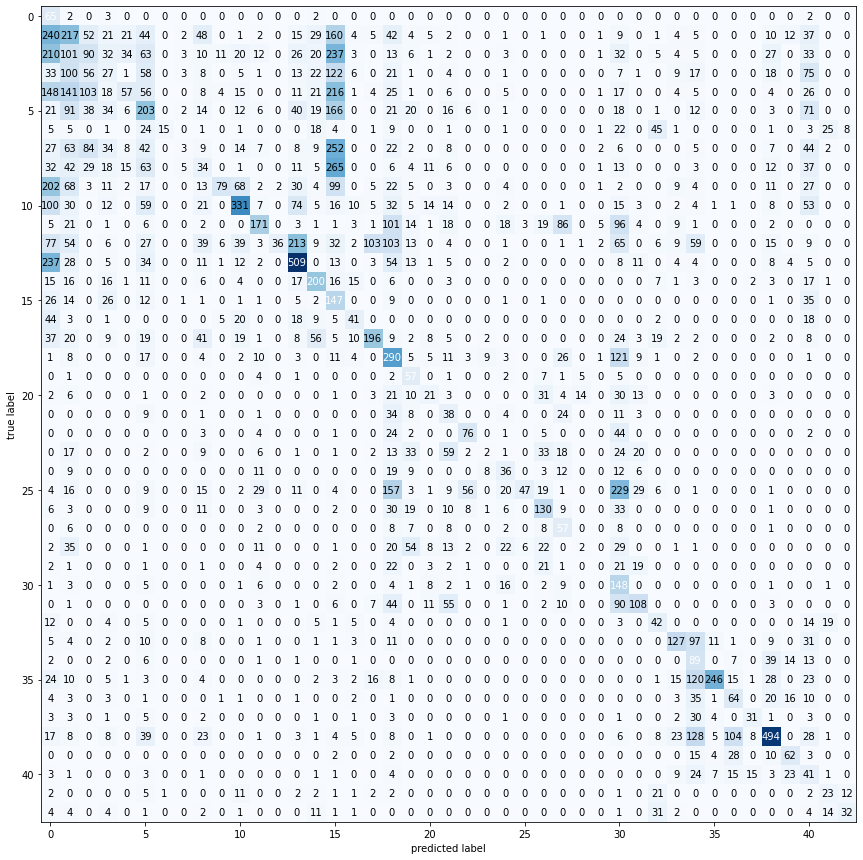

In [113]:
cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)
fig, ax = plot_confusion_matrix(conf_mat=cm,figsize=(15,15))
plt.show()

El método de PCA es visiblemente más preciso en este caso.

In [114]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.04      0.88      0.08        74
           1       0.19      0.22      0.20       995
           2       0.20      0.09      0.12      1004
           3       0.09      0.04      0.06       609
           4       0.39      0.06      0.11       897
           5       0.23      0.25      0.24       821
           6       0.94      0.08      0.14       192
           7       0.16      0.00      0.01       658
           8       0.10      0.06      0.07       613
           9       0.74      0.11      0.20       693
          10       0.57      0.40      0.47       825
          11       0.55      0.29      0.38       592
          12       0.95      0.04      0.07       934
          13       0.50      0.52      0.51       974
          14       0.44      0.56      0.49       360
          15       0.08      0.52      0.14       283
          16       0.34      0.25      0.29       166
          17       0.56    

### Algunos beneficios significativos de UMAP

En primer lugar, UMAP es rápido. Puede manejar grandes conjuntos de datos y datos de gran dimensión sin demasiada dificultad, escalando más allá de lo que la mayoría de los paquetes t-SNE pueden administrar. Esto incluye conjuntos de datos dispersos de muy alta dimensión. UMAP se ha utilizado con éxito directamente en datos con más de un millón de dimensiones.

En segundo lugar, UMAP se adapta bien a la dimensión de incrustación, **no es solo para visualización**. Puede usar UMAP como una técnica de reducción de dimensiones de propósito general como paso preliminar para otras tareas de aprendizaje automático. 

En tercer lugar, UMAP a menudo se desempeña mejor para preservar algunos aspectos de la estructura global de los datos que la mayoría de las implementaciones de t-SNE. Esto significa que a menudo puede proporcionar una mejor visión general de sus datos, además de preservar las relaciones con los vecinos locales.

En cuarto lugar, UMAP admite una amplia variedad de funciones de distancia, incluidas funciones de distancia no métricas como la distancia del coseno y la distancia de correlación.

En quinto lugar, UMAP admite la adición de nuevos puntos a una incrustación existente a través del método de transformación sklearn estándar.

En sexto lugar, UMAP admite la reducción de dimensión supervisada y semi-supervisada. Esto significa que si tiene información de etiqueta que desea utilizar como información adicional para la reducción de dimensión (incluso si es solo un etiquetado parcial), puede hacerlo, simplemente proporcionándola como el parámetro y en el método de ajuste.

Séptimo, UMAP admite una variedad de características experimentales adicionales que incluyen: una "transformada inversa" que puede aproximarse a una muestra de alta dimensión que se mapearía en una posición determinada en el espacio de incrustación; la capacidad de integrarse en espacios no euclidianos, incluidas las incrustaciones hiperbólicas y las incrustaciones con incertidumbre; también existe un soporte muy preliminar para incrustar marcos de datos.

Finalmente, UMAP tiene bases teóricas sólidas en el aprendizaje múltiple. Esto justifica el enfoque y permite más extensiones que pronto se agregarán a la biblioteca.

(Fuente: https://pypi.org/project/umap-learn/)